In [1]:
%autoreload 2

In [2]:
import os
import sys
sys.path.append(os.path.abspath('.'))
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../run'))

import copy
import gzip
import glob
import typing
import pickle

from IPython.display import display, Markdown

from collections import defaultdict
import numpy as np
import pandas as pd
from pandas.core.groupby import SeriesGroupBy  # type: ignore
import scipy
from scipy import stats
import tqdm.notebook as tqdm

from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.axes
import matplotlib.patches
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import patches
from matplotlib import path as mpath
import matplotlib.gridspec as gridspec

from simple_relational_reasoning.embeddings.visualizations import DEFAULT_COLORMAP, DEFAULT_BAR_KWARGS, DEFAULT_TEXT_KWARGS, DEFAULT_YLIM, plot_prettify, filter_and_group, save_plot  # type: ignore


In [3]:
with gzip.open('../containment_support_outputs/containment_support_v4_instance_maps.pkl.gz', 'rb') as f:
    maps = pickle.load(f)

print(maps.shape)

(20480, 640, 640)


In [4]:
unique_values = np.unique(maps)
unique_values

array([ 0, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23], dtype=uint16)

In [27]:
cmap = plt.get_cmap('tab10')
colors = [cmap(i) for i in range(len(unique_values) - 1)]
colors.insert(0, (0, 0, 0, 1))

color_arr = np.zeros((max(unique_values) + 1, 4))
for val, color in zip(unique_values, colors):
    color_arr[val] = color


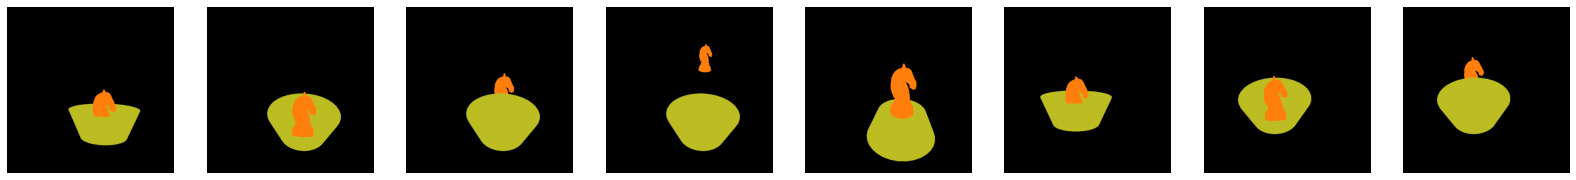

In [28]:
fig, axes = plt.subplots(1, 8, figsize=(28, 4))

for i, ax in enumerate(axes):
    ax.imshow(color_arr[maps[1 + i * 32]])
    ax.set_axis_off()

plt.show()

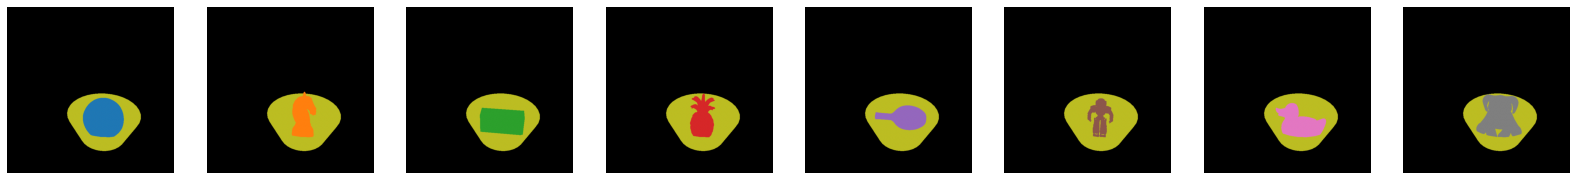

In [32]:
fig, axes = plt.subplots(1, 8, figsize=(28, 4))

for i, ax in enumerate(axes):
    ax.imshow(color_arr[maps[(32 * 1) + i]])
    ax.set_axis_off()

plt.show()

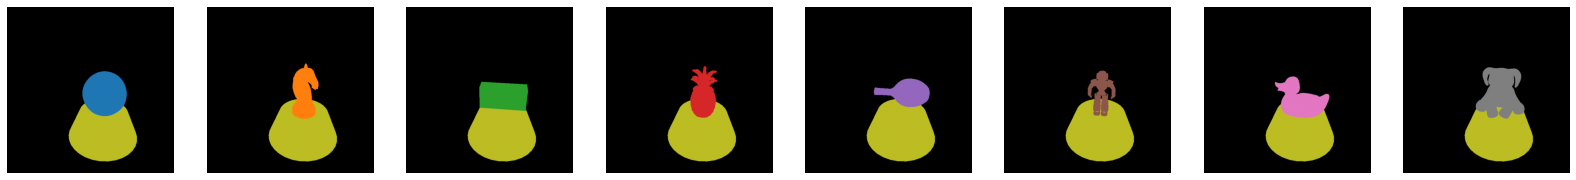

In [30]:
fig, axes = plt.subplots(1, 8, figsize=(28, 4))

for i, ax in enumerate(axes):
    ax.imshow(color_arr[maps[(32 * 4) + i]])
    ax.set_axis_off()

plt.show()

In [39]:
{t[0]: t[1] for t in zip(*np.unique(maps[7], return_counts=True))}

{0: 371420, 17: 9202, 18: 28978}

In [5]:
REPROCESS_DATA = False
DF_SAVE_PATH = '../containment_support_outputs/dataframes/containment_support_segmentation_maps_df.csv'

TARGET_OBJECTS = ['BeachBall', 'Knight', 'Lego', 'Pineapple', 'PingPong', 'Robot', 'RubberDuck', 'Teddy',]
REFERENCE_OBJECTS = ['Basket', 'CardboardBoxNoFlaps', 'ShortBoxNoFlaps', 'WoodenBasket']
SCENES_TYPES = ['Containment', 'High Containment', 'Behind', 'Far Behind', 'Support']

N_TARGET_OBJECTS = len(TARGET_OBJECTS)
N_REFERENCE_OBJECTS = len(REFERENCE_OBJECTS)
N_SCENE_TYPES = 5
N_IMAGES_PER_CONFIGURATION = N_TARGET_OBJECTS * N_REFERENCE_OBJECTS * N_SCENE_TYPES

BACKGROUND_COLOR_INDEX = 0
TARGET_COLOR_INDICES = [10, 11, 12, 13, 14, 15, 16, 17]
REFERENCE_COLOR_INDICES = [18, 20, 22, 23]


def index_to_scene_info(index: int) -> typing.Dict[str, typing.Any]:
    configuration_index = index // N_IMAGES_PER_CONFIGURATION
    image_index = index % N_IMAGES_PER_CONFIGURATION
    scene_type = image_index // (N_TARGET_OBJECTS * N_REFERENCE_OBJECTS)
    objects_index = image_index % (N_TARGET_OBJECTS * N_REFERENCE_OBJECTS)
    reference_object_index = objects_index // N_TARGET_OBJECTS
    target_object_index = objects_index % N_TARGET_OBJECTS
    example_index = configuration_index * (N_TARGET_OBJECTS * N_REFERENCE_OBJECTS) + (reference_object_index * N_TARGET_OBJECTS) + target_object_index

    return dict(
        original_index=index,
        configuration_index=configuration_index,
        example_index=example_index,
        scene_type=SCENES_TYPES[scene_type],
        reference_object=REFERENCE_OBJECTS[reference_object_index],
        target_object=TARGET_OBJECTS[target_object_index],
    )


def index_to_containment_index(index: int) -> int:
    configuration_index = index // N_IMAGES_PER_CONFIGURATION
    image_index = index % N_IMAGES_PER_CONFIGURATION
    containment_index = image_index % (N_TARGET_OBJECTS * N_REFERENCE_OBJECTS)
    return configuration_index * N_IMAGES_PER_CONFIGURATION + containment_index


def maps_to_df(scene_maps: np.ndarray) -> pd.DataFrame:
    rows = []
    for i in tqdm.tnrange(scene_maps.shape[0]):
        scene_info = index_to_scene_info(i)
        value_counts = {t[0]: t[1] for t in zip(*np.unique(scene_maps[i], return_counts=True))}
        del value_counts[BACKGROUND_COLOR_INDEX]
        for color_index, count in value_counts.items():
            if color_index in TARGET_COLOR_INDICES:
                scene_info['target_pixel_count'] = count
            elif color_index in REFERENCE_COLOR_INDICES:
                scene_info['reference_pixel_count'] = count
            else:
                raise ValueError(f'Unknown color index {color_index}')

        rows.append(scene_info)
        
    df = pd.DataFrame(rows)

    containment_df = df.loc[[index_to_containment_index(i) for i in df.index], :].reset_index()
    target_count_diff = df.target_pixel_count - containment_df.target_pixel_count
    target_count_ratio = df.target_pixel_count / containment_df.target_pixel_count
    reference_count_diff = df.reference_pixel_count - containment_df.reference_pixel_count
    reference_count_ratio = df.reference_pixel_count / containment_df.reference_pixel_count

    df = df.assign(
        target_count_diff=target_count_diff,
        target_count_ratio=target_count_ratio,
        reference_count_diff=reference_count_diff,
        reference_count_ratio=reference_count_ratio,
    )

    return df

if REPROCESS_DATA:
    maps_df = maps_to_df(maps)
    maps_df.to_csv(DF_SAVE_PATH, index=False)

else:
    maps_df = pd.read_csv(DF_SAVE_PATH)


print(maps_df.shape)
print(maps_df.columns)
maps_df.head()

(20480, 12)
Index(['original_index', 'configuration_index', 'example_index', 'scene_type',
       'reference_object', 'target_object', 'target_pixel_count',
       'reference_pixel_count', 'target_count_diff', 'target_count_ratio',
       'reference_count_diff', 'reference_count_ratio'],
      dtype='object')


,original_index,configuration_index,example_index,scene_type,reference_object,target_object,target_pixel_count,reference_pixel_count,target_count_diff,target_count_ratio,reference_count_diff,reference_count_ratio
0,0,0,0,Containment,Basket,BeachBall,9132,26717,0,1.0,0,1.0
1,1,0,1,Containment,Basket,Knight,6502,29950,0,1.0,0,1.0
2,2,0,2,Containment,Basket,Lego,6428,27180,0,1.0,0,1.0
3,3,0,3,Containment,Basket,Pineapple,5573,30336,0,1.0,0,1.0
4,4,0,4,Containment,Basket,PingPong,6437,27502,0,1.0,0,1.0


In [6]:
COUNT_KEYS = ['target_pixel_count', 'reference_pixel_count', 'target_count_diff', 'reference_count_diff', 'target_count_ratio', 'reference_count_ratio']
condensed_rows = []

for example_index in tqdm.tqdm(maps_df.example_index.unique()):
    ex_df = maps_df[(maps_df.example_index == example_index)]
    row_dict = dict(configuration_index = ex_df.configuration_index.iloc[0], example_index=example_index)

    for scene_type in SCENES_TYPES[1:]:
        scene_row = ex_df[(ex_df.scene_type == scene_type)]
        for count_key in COUNT_KEYS:
            row_dict[f'{"_".join(scene_type.lower().split(" "))}_{count_key}'] = scene_row[count_key].iloc[0]

    condensed_rows.append(row_dict)

condensed_maps_df = pd.DataFrame(condensed_rows)

print(condensed_maps_df.shape)
print(condensed_maps_df.columns)
condensed_maps_df.head()

  0%|          | 0/4096 [00:00<?, ?it/s]

(4096, 26)
Index(['configuration_index', 'example_index',
       'high_containment_target_pixel_count',
       'high_containment_reference_pixel_count',
       'high_containment_target_count_diff',
       'high_containment_reference_count_diff',
       'high_containment_target_count_ratio',
       'high_containment_reference_count_ratio', 'behind_target_pixel_count',
       'behind_reference_pixel_count', 'behind_target_count_diff',
       'behind_reference_count_diff', 'behind_target_count_ratio',
       'behind_reference_count_ratio', 'far_behind_target_pixel_count',
       'far_behind_reference_pixel_count', 'far_behind_target_count_diff',
       'far_behind_reference_count_diff', 'far_behind_target_count_ratio',
       'far_behind_reference_count_ratio', 'support_target_pixel_count',
       'support_reference_pixel_count', 'support_target_count_diff',
       'support_reference_count_diff', 'support_target_count_ratio',
       'support_reference_count_ratio'],
      dtype='object')


,configuration_index,example_index,high_containment_target_pixel_count,high_containment_reference_pixel_count,high_containment_target_count_diff,high_containment_reference_count_diff,high_containment_target_count_ratio,high_containment_reference_count_ratio,behind_target_pixel_count,behind_reference_pixel_count,...,far_behind_target_count_diff,far_behind_reference_count_diff,far_behind_target_count_ratio,far_behind_reference_count_ratio,support_target_pixel_count,support_reference_pixel_count,support_target_count_diff,support_reference_count_diff,support_target_count_ratio,support_reference_count_ratio
0,0,0,19137,26870,10005,153,2.095598,1.005727,7578,46007,...,-4104,19290,0.550591,1.722012,22869,41611,13737,14894,2.504271,1.557473
1,0,1,11434,34616,4932,4666,1.758536,1.155793,4058,46007,...,-2634,16057,0.594894,1.536127,14921,42810,8419,12860,2.294832,1.429382
2,0,2,15611,30396,9183,3216,2.428594,1.118322,4620,46007,...,-2051,18827,0.680927,1.692678,18337,43224,11909,16044,2.852676,1.590287
3,0,3,11225,34782,5652,4446,2.014175,1.146559,3817,46007,...,-1828,15671,0.671990,1.516581,14443,42942,8870,12606,2.591602,1.415546
4,0,4,11474,34533,5037,7031,1.782507,1.255654,3886,46007,...,-2637,18505,0.590337,1.672860,14168,46573,7731,19071,2.201025,1.693440


In [10]:
C_S_DF_SAVE_PATH = '../containment_support_outputs/dataframes/containment_support_df.csv'
combined_df = pd.read_csv(C_S_DF_SAVE_PATH)

print(combined_df.shape)
print(combined_df.columns)
combined_df.head()


(262144, 35)
Index(['full_model_name', 'model', 'training', 'flip', 'dino',
       'n_target_types', 'configuration_index', 'example_index',
       'reference_object', 'target_object', 'seed', 'unpooled_output',
       'containment_high_containment_cos', 'containment_behind_cos',
       'containment_far_behind_cos', 'containment_support_cos',
       'high_containment_behind_cos', 'high_containment_far_behind_cos',
       'high_containment_support_cos', 'behind_far_behind_cos',
       'behind_support_cos', 'far_behind_support_cos',
       'high_containment_vs_behind', 'high_containment_vs_behind_diff',
       'high_containment_vs_behind_ratio', 'high_containment_vs_far_behind',
       'high_containment_vs_far_behind_diff',
       'high_containment_vs_far_behind_ratio', 'high_containment_vs_support',
       'high_containment_vs_support_diff', 'high_containment_vs_support_ratio',
       'behind_similar', 'far_behind_similar', 'support_similar',
       'high_containment_similar'],
      dt

/Users/guydavidson/opt/anaconda3/envs/torch/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3397: DtypeWarning: Columns (3,4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,full_model_name,model,training,flip,dino,n_target_types,configuration_index,example_index,reference_object,target_object,...,high_containment_vs_far_behind,high_containment_vs_far_behind_diff,high_containment_vs_far_behind_ratio,high_containment_vs_support,high_containment_vs_support_diff,high_containment_vs_support_ratio,behind_similar,far_behind_similar,support_similar,high_containment_similar
0,mobilenet-saycam(S),mobilenet,saycam(S),NaN,NaN,1,0,0,Basket,BeachBall,...,True,0.007056,1.009127,True,0.022993,1.030366,False,False,False,True
1,mobilenet-saycam(S),mobilenet,saycam(S),NaN,NaN,1,0,1,Basket,Knight,...,True,0.033865,1.040573,True,0.066863,1.083405,False,False,False,True
2,mobilenet-saycam(S),mobilenet,saycam(S),NaN,NaN,1,0,2,Basket,Lego,...,True,0.009470,1.011536,True,0.046757,1.059669,False,False,False,True
3,mobilenet-saycam(S),mobilenet,saycam(S),NaN,NaN,1,0,3,Basket,Pineapple,...,True,0.036096,1.045683,True,0.062260,1.081494,False,False,False,True
4,mobilenet-saycam(S),mobilenet,saycam(S),NaN,NaN,1,0,4,Basket,PingPong,...,False,-0.001558,0.998185,True,0.050519,1.062632,False,True,False,False


In [71]:
merged_df = combined_df.merge(condensed_maps_df, how='left', on=['configuration_index', 'example_index'], suffixes=('', '_seg'))

print(merged_df.shape)
print(merged_df.columns)
merged_df.head()

(262144, 59)
Index(['full_model_name', 'model', 'training', 'flip', 'dino',
       'n_target_types', 'configuration_index', 'example_index',
       'reference_object', 'target_object', 'seed', 'unpooled_output',
       'containment_high_containment_cos', 'containment_behind_cos',
       'containment_far_behind_cos', 'containment_support_cos',
       'high_containment_behind_cos', 'high_containment_far_behind_cos',
       'high_containment_support_cos', 'behind_far_behind_cos',
       'behind_support_cos', 'far_behind_support_cos',
       'high_containment_vs_behind', 'high_containment_vs_behind_diff',
       'high_containment_vs_behind_ratio', 'high_containment_vs_far_behind',
       'high_containment_vs_far_behind_diff',
       'high_containment_vs_far_behind_ratio', 'high_containment_vs_support',
       'high_containment_vs_support_diff', 'high_containment_vs_support_ratio',
       'behind_similar', 'far_behind_similar', 'support_similar',
       'high_containment_similar', 'high_con

,full_model_name,model,training,flip,dino,n_target_types,configuration_index,example_index,reference_object,target_object,...,far_behind_target_count_diff,far_behind_reference_count_diff,far_behind_target_count_ratio,far_behind_reference_count_ratio,support_target_pixel_count,support_reference_pixel_count,support_target_count_diff,support_reference_count_diff,support_target_count_ratio,support_reference_count_ratio
0,mobilenet-saycam(S),mobilenet,saycam(S),NaN,NaN,1,0,0,Basket,BeachBall,...,-4104,19290,0.550591,1.722012,22869,41611,13737,14894,2.504271,1.557473
1,mobilenet-saycam(S),mobilenet,saycam(S),NaN,NaN,1,0,1,Basket,Knight,...,-2634,16057,0.594894,1.536127,14921,42810,8419,12860,2.294832,1.429382
2,mobilenet-saycam(S),mobilenet,saycam(S),NaN,NaN,1,0,2,Basket,Lego,...,-2051,18827,0.680927,1.692678,18337,43224,11909,16044,2.852676,1.590287
3,mobilenet-saycam(S),mobilenet,saycam(S),NaN,NaN,1,0,3,Basket,Pineapple,...,-1828,15671,0.671990,1.516581,14443,42942,8870,12606,2.591602,1.415546
4,mobilenet-saycam(S),mobilenet,saycam(S),NaN,NaN,1,0,4,Basket,PingPong,...,-2637,18505,0.590337,1.672860,14168,46573,7731,19071,2.201025,1.693440


In [8]:
def normalize(x: np.ndarray) -> np.ndarray:
    return (x - x.mean()) / x.std()


def corr(x: np.ndarray, y: np.ndarray) -> float:
    x_norm = normalize(x)
    y_norm = normalize(y)
    pearson_r_result = stats.pearsonr(x_norm, y_norm)
    return pearson_r_result

(0.01386293403654578, 0.37507911624217)
(-0.09266623900785327, 2.8222467292149237e-09)
Basket (0.5080860703877889, 2.6366537870434276e-68)
CardboardBoxNoFlaps (-0.016581189748134897, 0.5961213330688392)
ShortBoxNoFlaps (-0.060529441736187316, 0.05282460074378248)
WoodenBasket (0.41333282670906224, 1.5918042090755976e-43)


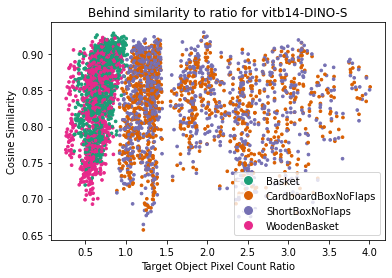

In [12]:
model_name = 'vitb14-DINO-S'
small_df = merged_df[(merged_df.full_model_name == model_name) & (merged_df.unpooled_output == False)]

ref_obj_indices = {ref_obj: i for i, ref_obj in enumerate(REFERENCE_OBJECTS)}

print(corr(small_df.containment_high_containment_cos, small_df.high_containment_target_count_ratio))
print(corr(small_df.containment_behind_cos, small_df.behind_target_count_ratio))

cmap = plt.cm.Dark2
plt.scatter(small_df.behind_target_count_ratio, small_df.containment_behind_cos, color=[cmap(ref_obj_indices[r]) for r in small_df.reference_object], s=7)
legend_elements = [matplotlib.lines.Line2D([0], [0], marker='o', color='w', label=ref_obj, markerfacecolor=cmap(i), markersize=10) for ref_obj, i in ref_obj_indices.items()]
plt.legend(handles=legend_elements)
plt.xlabel('Target Object Pixel Count Ratio')
plt.ylabel('Cosine Similarity')
plt.title(f'Behind similarity to ratio for {model_name}')

for reference_object in small_df.reference_object.unique():
    ref_df = small_df[(small_df.reference_object == reference_object)]
    print(reference_object, corr(ref_df.containment_behind_cos, ref_df.behind_target_count_ratio))

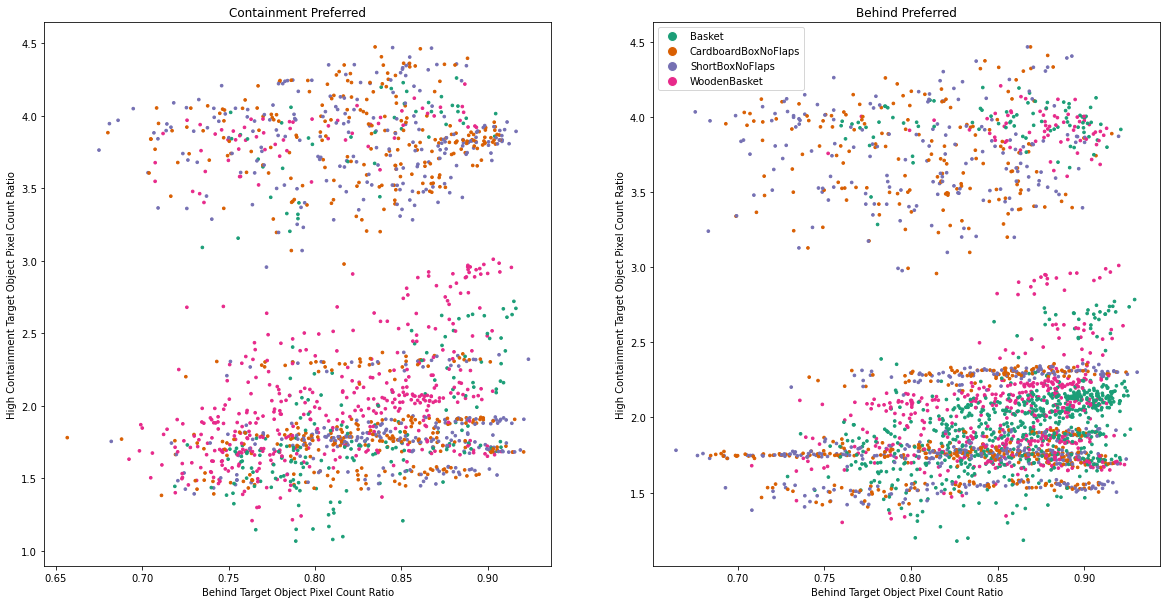

In [21]:

model_name = 'vitb14-DINO-S'
small_df = merged_df[(merged_df.full_model_name == model_name) & (merged_df.unpooled_output == False)]

ref_obj_indices = {ref_obj: i for i, ref_obj in enumerate(REFERENCE_OBJECTS)}

# print(corr(small_df.containment_high_containment_cos, small_df.high_containment_target_count_ratio))
# print(corr(small_df.containment_behind_cos, small_df.behind_target_count_ratio))

cmap = plt.cm.Dark2
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
containment_preferred_ax = axes[0]
behind_preferred_ax = axes[1]

containment_preferred_indices = small_df.containment_high_containment_cos >= small_df.containment_behind_cos
behind_preferred_indices = small_df.containment_high_containment_cos < small_df.containment_behind_cos

containment_preferred_ax.scatter(
    small_df.containment_behind_cos[containment_preferred_indices], 
    small_df.high_containment_target_count_ratio[containment_preferred_indices],
    color=[cmap(ref_obj_indices[r]) for r in small_df.reference_object[containment_preferred_indices]], s=7)
containment_preferred_ax.set_title('Containment Preferred')

behind_preferred_ax.scatter(
    small_df.containment_behind_cos[behind_preferred_indices], 
    small_df.high_containment_target_count_ratio[behind_preferred_indices],
    color=[cmap(ref_obj_indices[r]) for r in small_df.reference_object[behind_preferred_indices]], s=7)
behind_preferred_ax.set_title('Behind Preferred')

legend_elements = [matplotlib.lines.Line2D([0], [0], marker='o', color='w', label=ref_obj, markerfacecolor=cmap(i), markersize=10) for ref_obj, i in ref_obj_indices.items()]
plt.legend(handles=legend_elements)

for ax in axes:
    ax.set_xlabel('Behind Target Object Pixel Count Ratio')
    ax.set_ylabel('High Containment Target Object Pixel Count Ratio')



In [51]:
REFERENCE_OBJECTS

['Basket', 'CardboardBoxNoFlaps', 'ShortBoxNoFlaps', 'WoodenBasket']

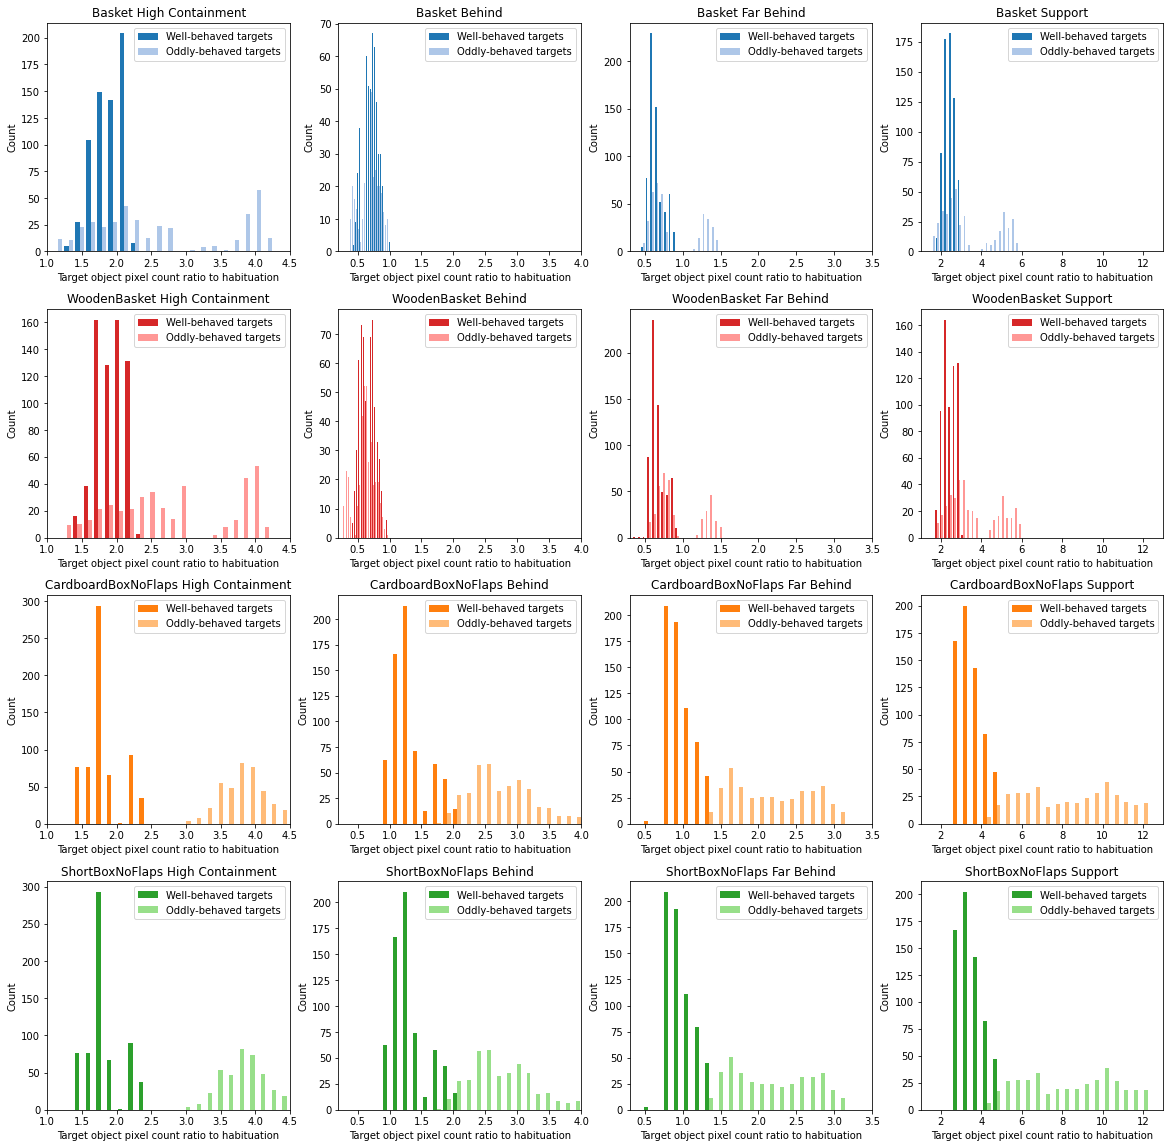

In [53]:
fig, axes = plt.subplots(4, 4, figsize=(20, 20))

XLIMS = {
    'High Containment': (1.0, 4.5), 
    'Behind': (0.2, 4.0), 
    'Far Behind': (0.3, 3.5), 
    'Support': (1, 13)
}

WEIRD_TARGET_OBJECTS = ['Lego', 'PingPong', 'RubberDuck']
weird_target_object_indices = small_df.target_object.isin(WEIRD_TARGET_OBJECTS)

tab20 = plt.cm.get_cmap('tab20')

for r, reference_object in enumerate(['Basket', 'WoodenBasket', 'CardboardBoxNoFlaps', 'ShortBoxNoFlaps']):
    i = ref_obj_indices[reference_object]
    for j, scene_type in enumerate(SCENES_TYPES[1:]):    
        ax = axes[r][j]
        key = f'{scene_type.lower().replace(" ", "_")}_target_count_ratio'
        ax.hist([
            small_df[key][(small_df.reference_object == reference_object) & (~weird_target_object_indices)],
            small_df[key][(small_df.reference_object == reference_object) & (weird_target_object_indices)]
        ],
        bins=20, color=tab20.colors[2 * i: 2 * i + 2], label=['Well-behaved targets', 'Oddly-behaved targets'])
        ax.set_title(f'{reference_object} {scene_type}')
        ax.set_xlim(*XLIMS[scene_type])
        ax.set_xlabel('Target object pixel count ratio to habituation')
        ax.set_ylabel('Count')
        ax.legend()

plt.subplots_adjust(hspace=0.25)

plt.show()

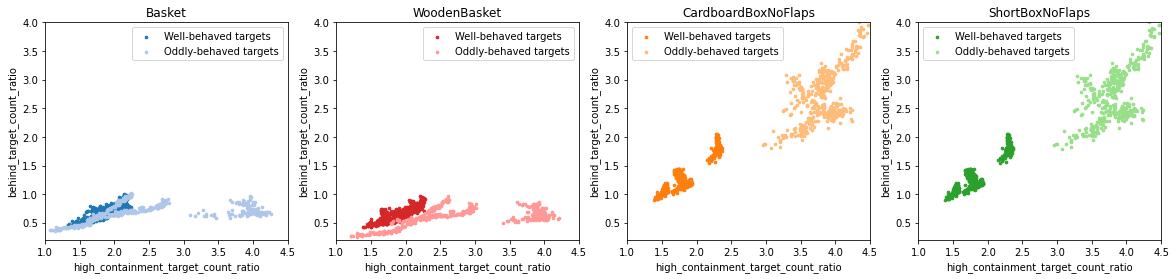

In [59]:
fig, axes = plt.subplots(1, 4, figsize=(20, 4))


WEIRD_TARGET_OBJECTS = ['Lego', 'PingPong', 'RubberDuck']
weird_target_object_indices = small_df.target_object.isin(WEIRD_TARGET_OBJECTS)

SCENES_TYPES_TO_PLOT = ['High Containment', 'Behind']

tab20 = plt.cm.get_cmap('tab20')



for r, reference_object in enumerate(['Basket', 'WoodenBasket', 'CardboardBoxNoFlaps', 'ShortBoxNoFlaps']):
    i = ref_obj_indices[reference_object]
    ax = axes[r]
    
    keys = [f'{scene_type.lower().replace(" ", "_")}_target_count_ratio' for scene_type in SCENES_TYPES_TO_PLOT]

    ax.scatter(*[small_df[key][(small_df.reference_object == reference_object) & (~weird_target_object_indices)] for key in keys],
        color=tab20.colors[2 * i], s=7, label='Well-behaved targets')
    ax.scatter(*[small_df[key][(small_df.reference_object == reference_object) & (weird_target_object_indices)] for key in keys],
        color=tab20.colors[2 * i + 1], s=7, label='Oddly-behaved targets')

    ax.set_title(f'{reference_object}')
    # ax.set_xlim(*XLIMS[scene_type])
    ax.set_xlabel(keys[0])
    ax.set_ylabel(keys[1])
    ax.set_xlim(1.0, 4.5)
    ax.set_ylim(0.2, 4.0)
    ax.legend()

plt.show()

In [ ]:
for target_object in small_df.target_object.unique():
    fig, axes = plt.subplots(4, 4, figsize=(20, 20))

    plt.suptitle(target_object)

    for reference_object , i in ref_obj_indices.items():
        for j, scene_type in enumerate(SCENES_TYPES[1:]):    
            ax = axes[i][j]
            key = f'{scene_type.lower().replace(" ", "_")}_target_count_ratio'
            ax.hist(small_df[key][(small_df.reference_object == reference_object) & (small_df.target_object == target_object)], bins=50, color=cmap(i))
            ax.set_title(f'{reference_object} {scene_type}')
            ax.set_xlim(*xlims[scene_type])

    plt.show()

In [72]:
merged_df = merged_df.assign(matched_behind=(0.5 <= merged_df.behind_target_count_ratio) & (merged_df.behind_target_count_ratio <= 1.5))
merged_df = merged_df.assign(matched_behind_high=(merged_df.matched_behind) & (merged_df.high_containment_target_count_ratio <= 3.0))

In [73]:
partial_df = merged_df[['configuration_index', 'example_index', 'matched_behind', 'matched_behind_high']]
partial_df.head()

,configuration_index,example_index,matched_behind,matched_behind_high
0,0,0,True,True
1,0,1,True,True
2,0,2,True,True
3,0,3,True,True
4,0,4,True,True


In [74]:
partial_df.shape

(262144, 4)

In [75]:
partial_df.to_csv('../containment_support_outputs/dataframes/containment_support_stimuli_match_df.csv', index=False)